# Ensemble learning

Meng Lu

####   Content
1. XGBoost
2. H2o framework: random forest and XGBoost
3. Model interpretation
4. Accuracy assessment

In [33]:
import numpy as np  
import pandas as pd 
import matplotlib.pyplot as plt
import random

import shap # model interpretation
import xgboost as xgb #xgb

#h2o framework
from h2o.automl import H2OAutoML
import h2o
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators import H2OXGBoostEstimator

# scikit learn tools.
from sklearn.metrics import r2_score, explained_variance_score, mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
 
from importlib.metadata import version

In [18]:
# We can define a function for exporting the accuracy metrics later. 
def performance (actural, pred):
    r2 = r2_score(actural, pred)
    expvar = explained_variance_score(actural, pred)
    mae = mean_absolute_error(actural, pred)
    #RMSE
    rmse = np.sqrt(mean_squared_error(actural, pred))
    # for between data-set comparison
    mape = mean_absolute_percentage_error(actural, pred)
    m ={"R2":r2, "expvar":expvar,"MAE": mae, "RMSE": rmse, "MAPE": mape}
    return (m)

In [19]:
#import statsmodels.api as sm
spreadurl = 'https://raw.githubusercontent.com/mengluchu/uncertainty/master/data_vis_exp/DENL17_uc.csv'
# load the data
ap = pd.read_csv(spreadurl)

In [20]:
random.seed(1)

X_regex="pop|nightlight|trop|ele|wind|temp|ind|GH|road|Traffic"
predvar = "wkd_day_value"

#shuffle for easy sampling
ap = ap.sample(frac=1)
res = 100
if res == 100:
    ap = ap.drop(ap.filter(regex='_25$|_50$').columns, axis = 1)
 
X = ap.filter(regex=X_regex)
#X["tra_100"]=X.Daily_Traffic_5km*X.road_class_2_100
y= ap[predvar] # nothing with 10， 11， 12 13 ,1, 5, 7，
 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=7)


[0]	test-rmse:41.34208
[100]	test-rmse:34.52916
[200]	test-rmse:29.22324
[300]	test-rmse:25.14260
[400]	test-rmse:21.79151
[499]	test-rmse:19.26006


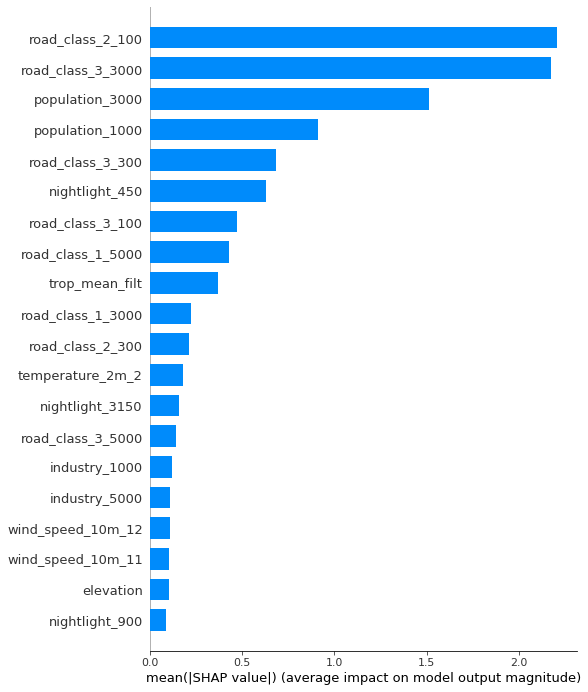

In [21]:
# one way of running the xgboost
d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)
#Train the model
params = {
    "eta": 0.002, 
    "subsample": 0.8,
    'max_depth': 6, 
}

model = xgb.train(params, d_train, 500, evals = [(d_test, "test")], verbose_eval=100, early_stopping_rounds=20)

#variable importance.
shap_values = shap.TreeExplainer(model).shap_values(X) # mean importance

fig, axes = plt.subplots(nrows = 1, ncols = 1, constrained_layout=True) 
shap.summary_plot(shap_values, X.columns, plot_type="bar")
#fig.savefig('/Volumes/Meng_Mac/obia/temp/tree.png')  


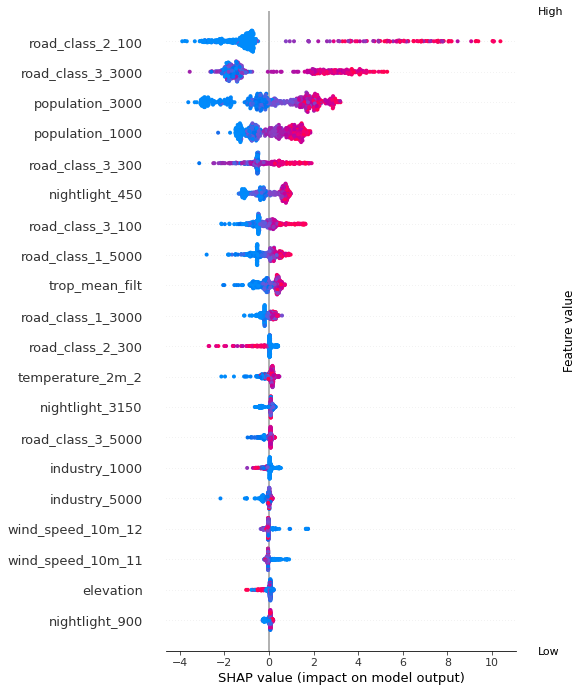

In [22]:

# Negative and positive contributions, and local interpretability: the effect of each individual sample.  
fig, axes = plt.subplots(nrows = 1,ncols = 1,constrained_layout=True) 
shap.summary_plot(shap_values, X)
#fig.savefig("shap.png")
#road_class_2_100 affects a few predictions by a large amount, while population_1000 affects all predictions by a smaller amount.



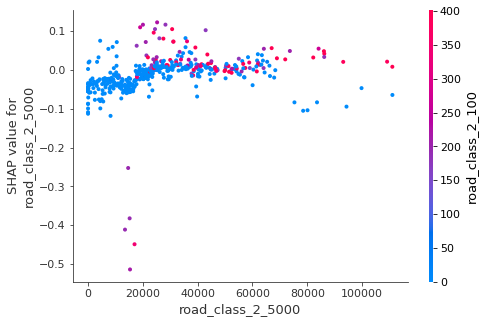

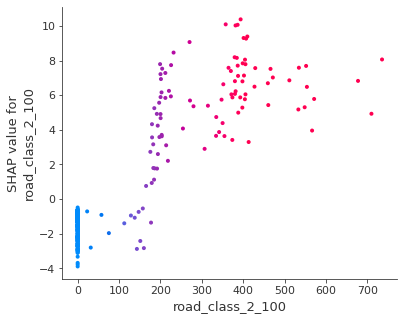

In [23]:
shap.dependence_plot("road_class_2_5000", shap_values, X)
shap.dependence_plot("road_class_2_100", shap_values, X,interaction_index = "road_class_2_100") 
 
#plt.close("all")
 

In [26]:
### h2o Framework
h2o.init()
#h2o.connect()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_261"; Java(TM) SE Runtime Environment (build 1.8.0_261-b12); Java HotSpot(TM) 64-Bit Server VM (build 25.261-b12, mixed mode)
  Starting server from /Users/menglu/opt/anaconda3/envs/geoml/lib/python3.8/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/rr/_qyztvbd1k94w56cm5rjl_380000gn/T/tmpmscetpzi
  JVM stdout: /var/folders/rr/_qyztvbd1k94w56cm5rjl_380000gn/T/tmpmscetpzi/h2o_menglu_started_from_python.out
  JVM stderr: /var/folders/rr/_qyztvbd1k94w56cm5rjl_380000gn/T/tmpmscetpzi/h2o_menglu_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Berlin
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.1
H2O_cluster_version_age:,24 days
H2O_cluster_name:,H2O_from_python_menglu_84g7vs
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.778 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


In [28]:

#if you cannot connect to h2o
#h2o.init(ip="127.0.0.1")
train, test = train_test_split(ap,test_size=0.1,random_state=1234)
#df_hex = h2o.H2OFrame(ap)
train_hex = h2o.H2OFrame(train)
test_hex = h2o.H2OFrame(test)

predictors =list(ap.filter(regex=X_regex))
target=predvar

#prediction and add to the actual
def actual_predict(model,test_hex,target):
    y_pred = model.predict(test_hex).as_data_frame()
    y_actual = test_hex[target].as_data_frame()
    df_actual_predict = pd.concat([y_actual,y_pred],axis=1)
    df_actual_predict.columns = ['actual','pred']
    return(df_actual_predict)


RF_modl = H2ORandomForestEstimator(
        model_id = 'RF',
        ntrees = 500,
        nfolds=10,
        min_rows=100,
        seed=1234)

RF_modl.train(predictors,target,training_frame=train_hex)

RF_actual_predict = actual_predict(RF_modl,test_hex,target)
RF_actual_predict.head()


Connecting to H2O server at http://localhost:54321 ... successful.


H2O_cluster_uptime:,1 min 14 secs
H2O_cluster_timezone:,Europe/Berlin
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.1
H2O_cluster_version_age:,24 days
H2O_cluster_name:,H2O_from_python_menglu_84g7vs
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.758 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


,actual,pred
0,14.404490,18.060812
1,12.769964,24.947402
2,52.688570,37.706172
3,24.415953,22.036801
4,12.215662,25.152336


In [34]:
performance(RF_actual_predict.actual, RF_actual_predict.pred)

{'R2': 0.46565182970076036,
 'expvar': 0.47959874557660864,
 'MAE': 7.1962377889849565,
 'RMSE': 10.155152080482779,
 'MAPE': 0.3880293651991634}

In [36]:
XGB_modl = H2OXGBoostEstimator(
        model_id = 'XGB_modl',
        fold_assignment = "Modulo", #fixed fold, for comparing with other models, you can also try "Auto", "Modulo", and "Stratified"
        max_depth = 5, 
         eta = 0.002, 
        subsample=0.8,
        keep_cross_validation_predictions=True,
        ntrees = 1000,
        nfolds=10,
        min_rows=100,
        seed=1234)
XGB_modl.train(predictors,target,training_frame=train_hex)
#a = XGB_modl.cross_validation_predictions()
#len(a)

XGB_actual_predict = actual_predict(XGB_modl,test_hex,target)


# performance on the validation data for each fold. 
performance(XGB_actual_predict['actual'], XGB_actual_predict['pred'])


xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%


{'R2': 0.530044226871632,
 'expvar': 0.5531342710641762,
 'MAE': 5.907745193911375,
 'RMSE': 9.523635448163878,
 'MAPE': 0.24668629887346738}

In [37]:
# we can compare with model performance on training 
XGB_modl.model_performance()



ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 127.98444465476582
RMSE: 11.31302102246636
MAE: 7.728277059955905
RMSLE: 0.34281249559165206
Mean Residual Deviance: 127.98444465476582


# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

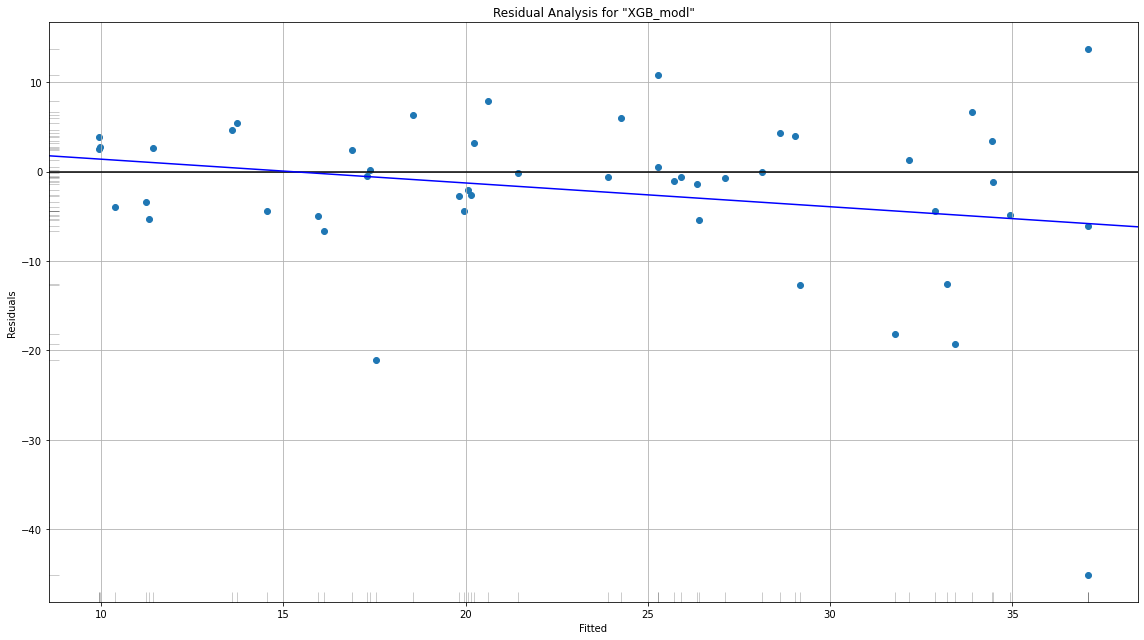

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

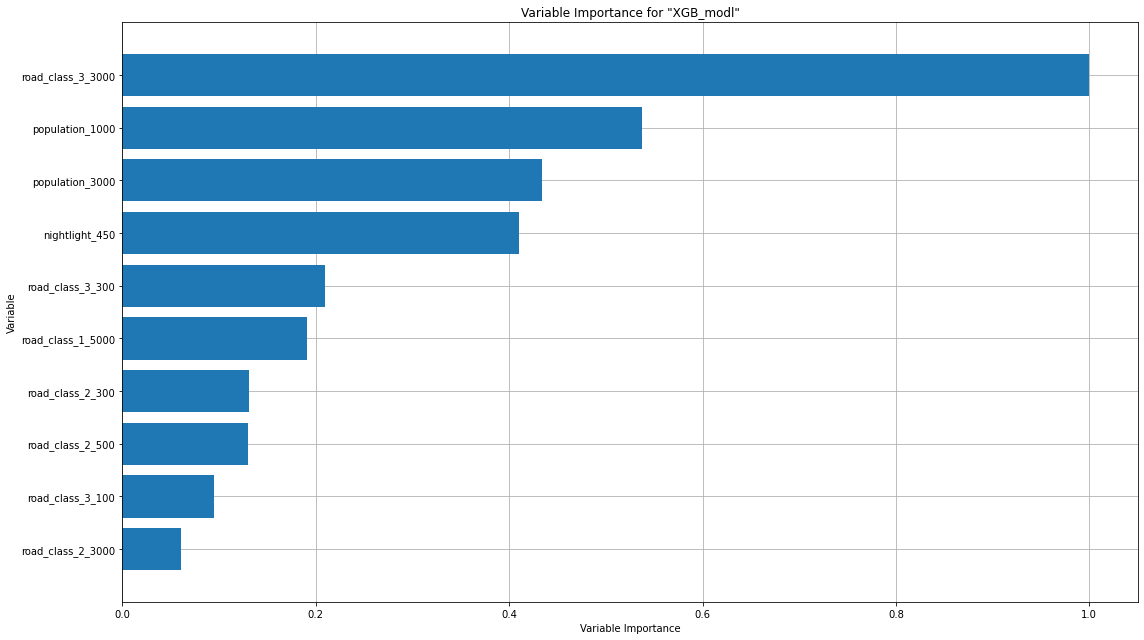

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

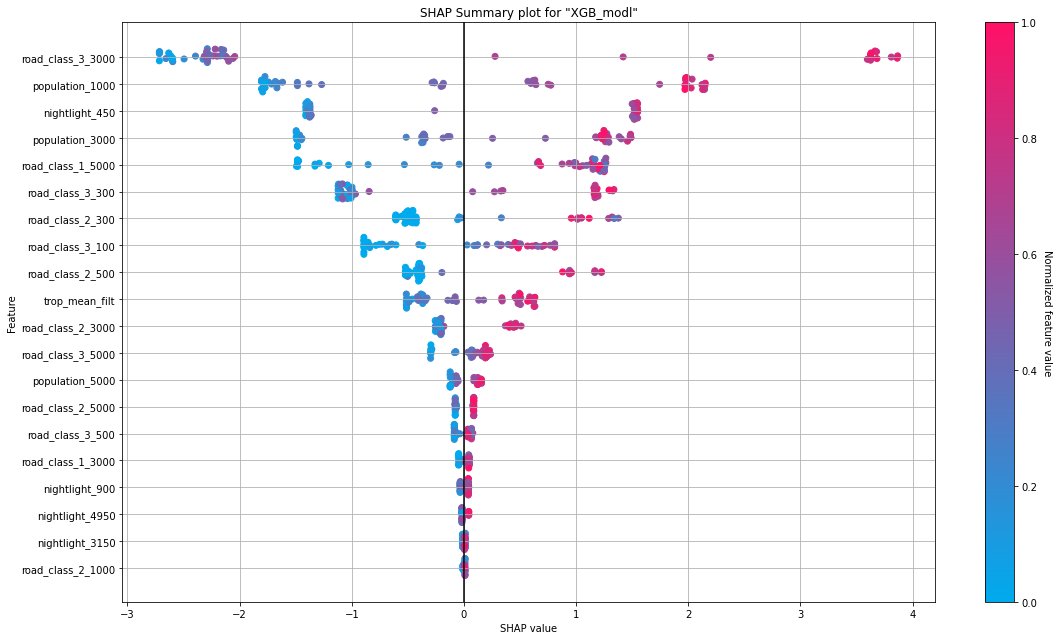

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

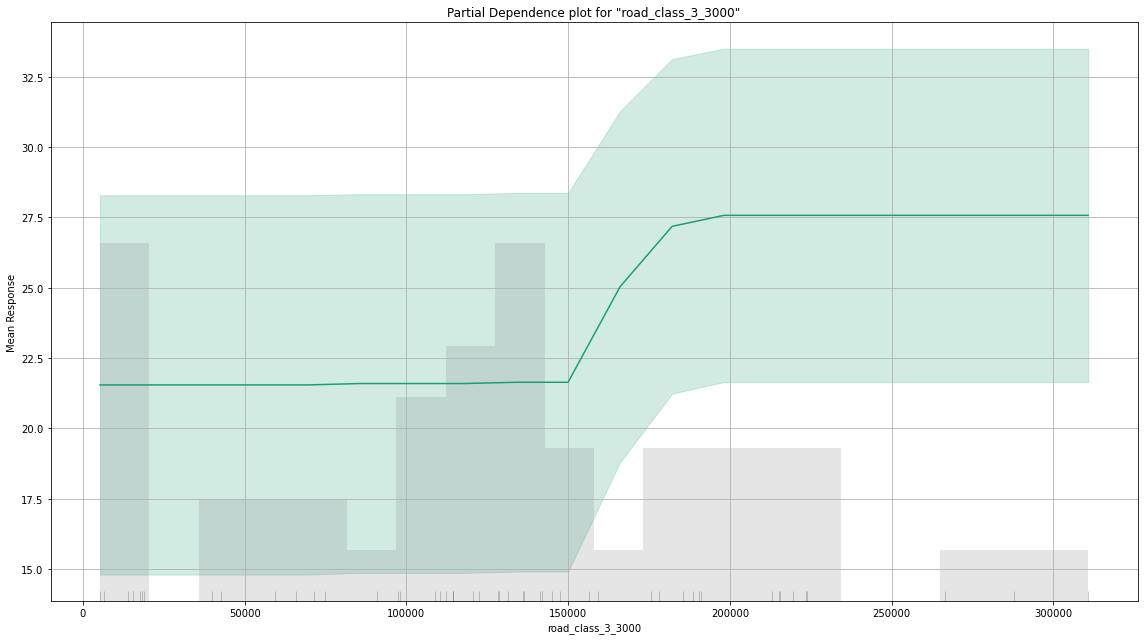

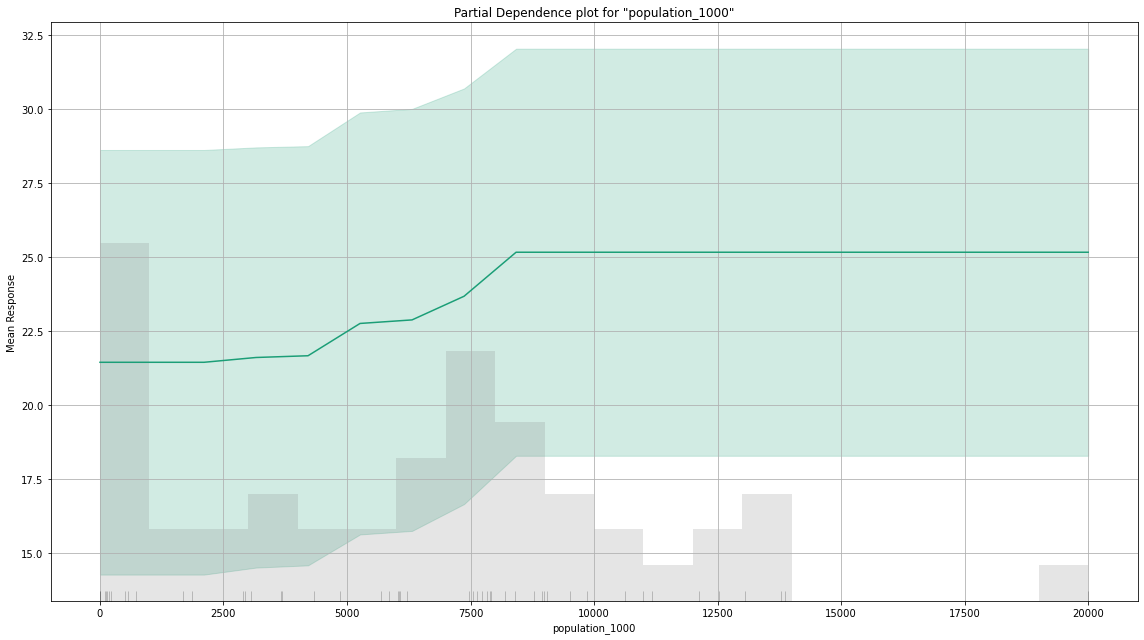

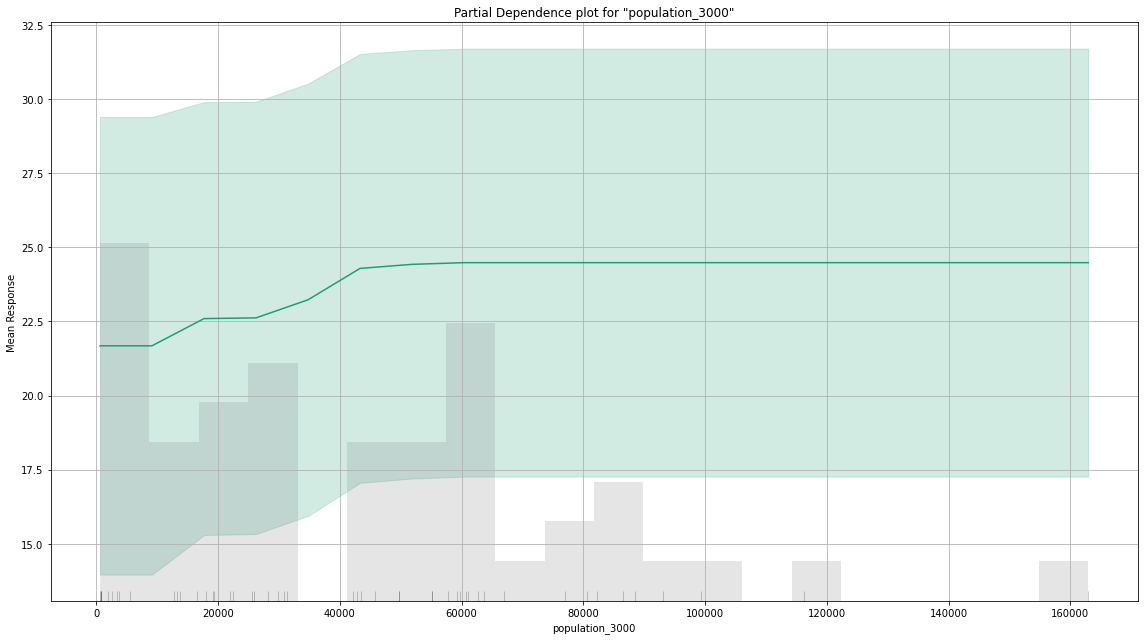

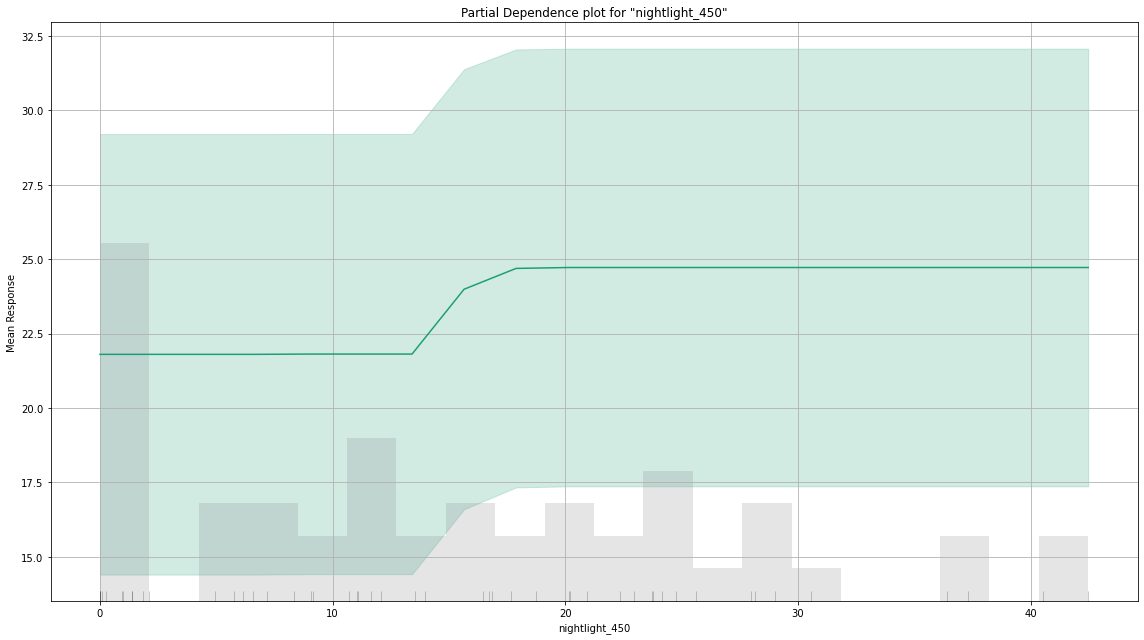

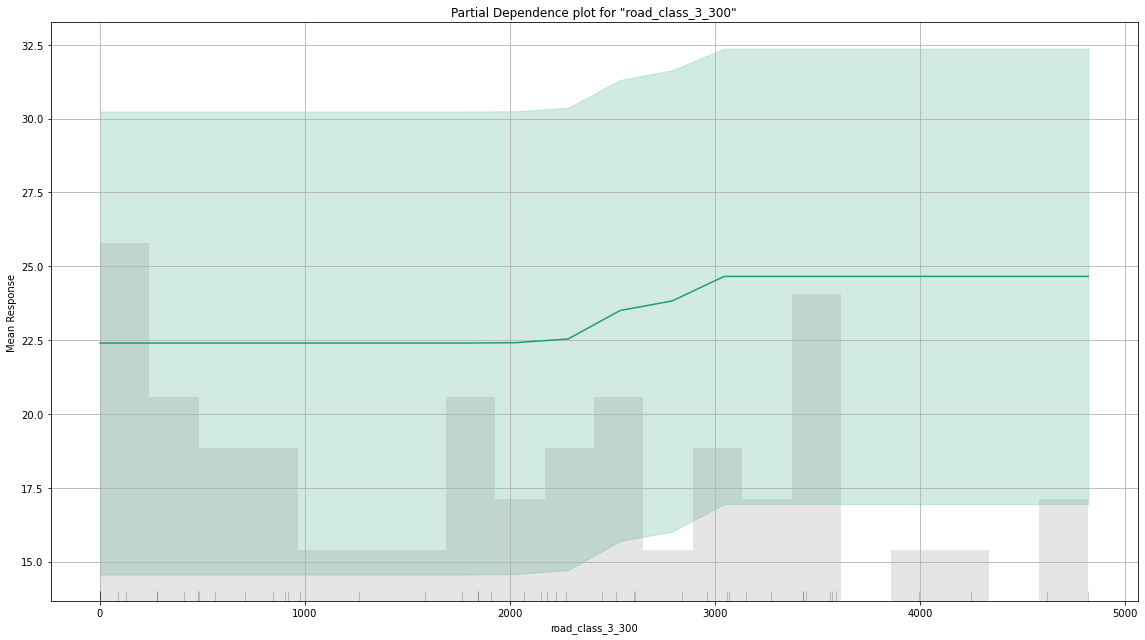

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

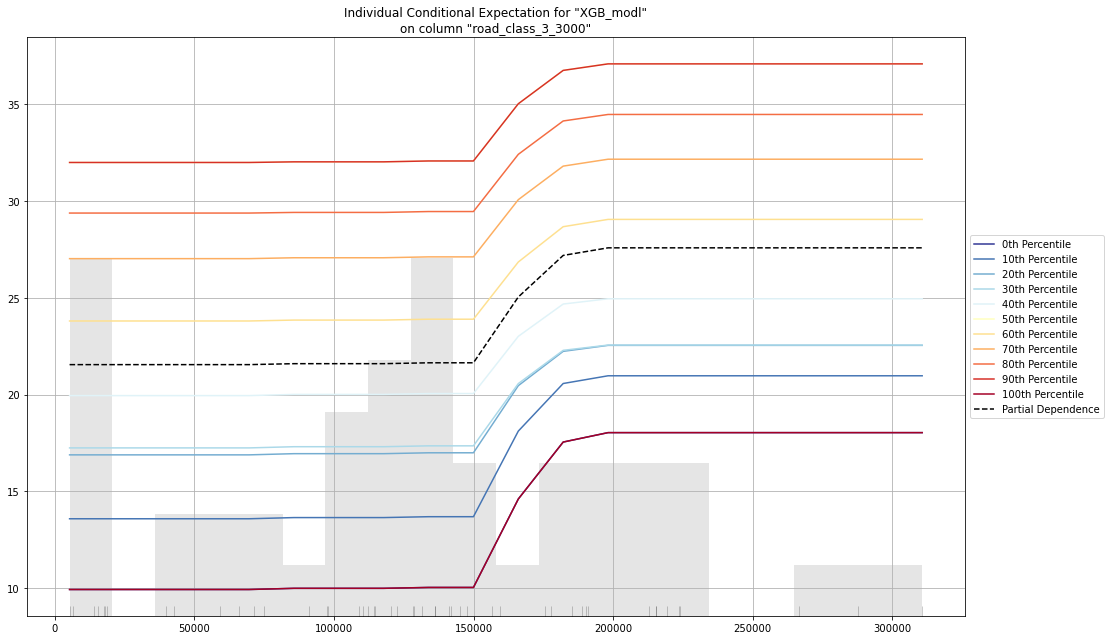

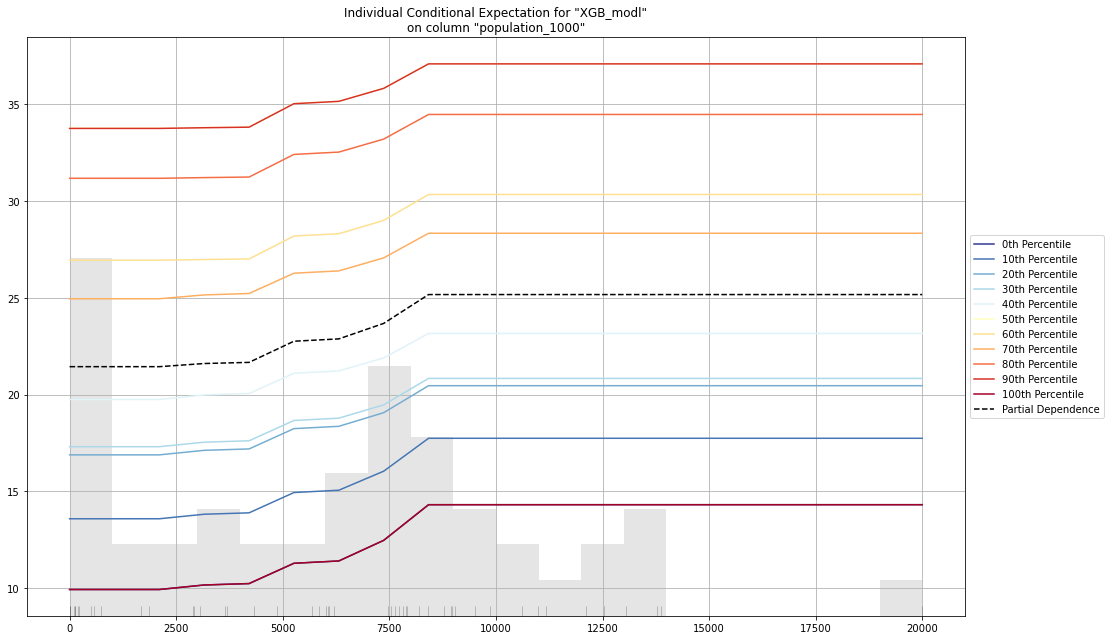

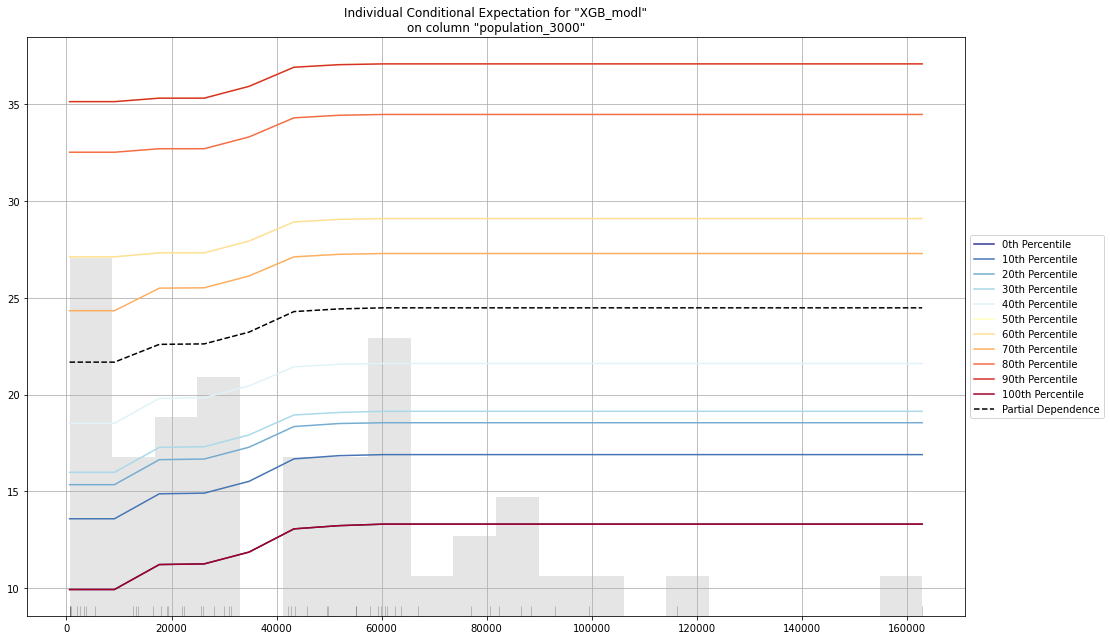

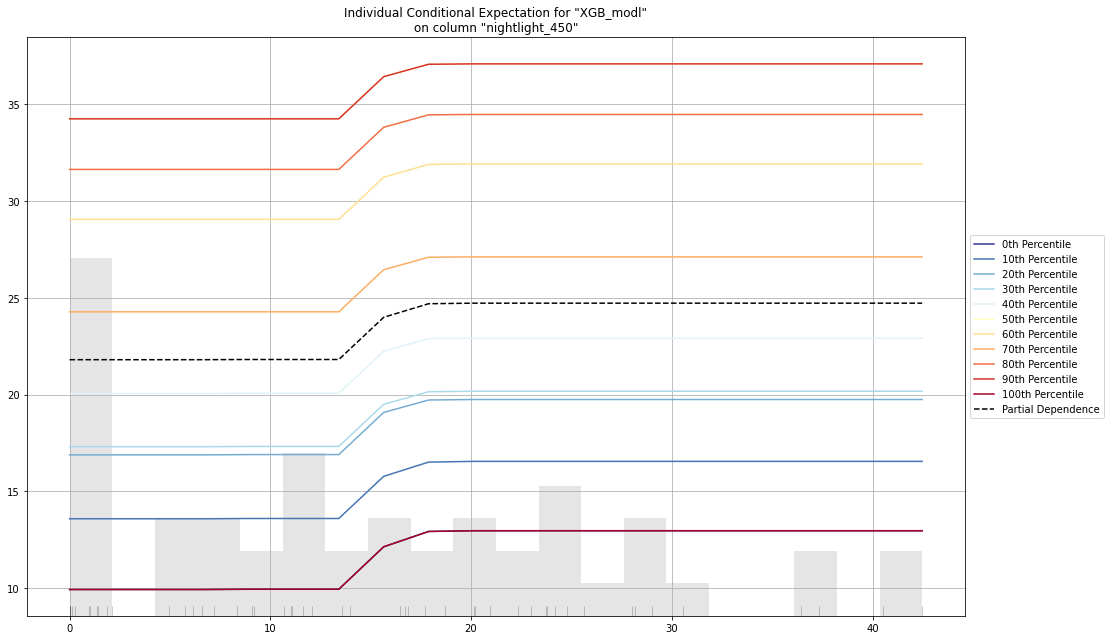

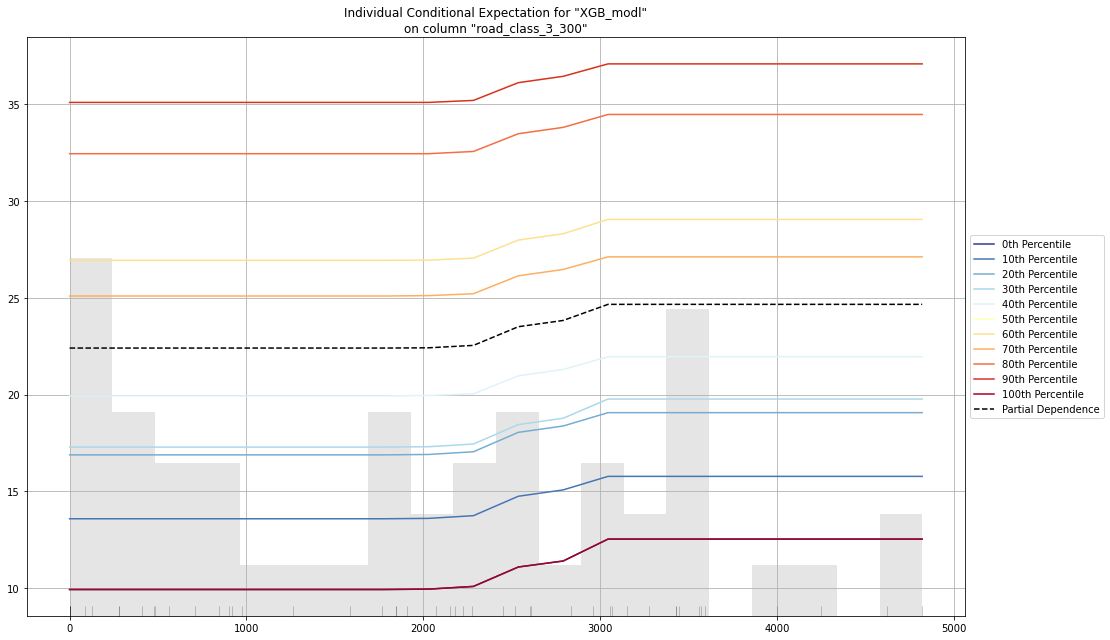



odict_keys(['residual_analysis', 'varimp', 'shap_summary', 'pdp', 'ice'])


In [38]:
exm = XGB_modl.explain(test_hex)
#exm = XGB_modl.explain_row(test_hex, row_index = 0) # a different way for the same results

In [39]:
print(exm.keys())

odict_keys(['residual_analysis', 'varimp', 'shap_summary', 'pdp', 'ice'])


# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

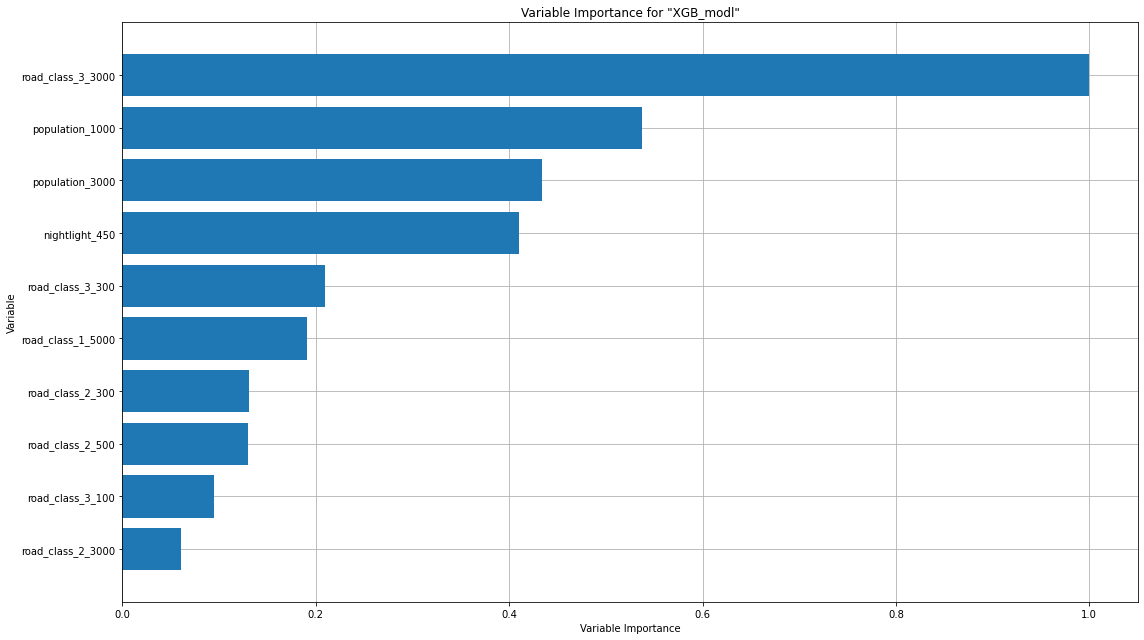

In [40]:
exm["varimp"] # only looking at variable importance

In [43]:
#['residual_analysis', 'varimp', 'shap_summary', 'pdp', 'ice']
aml = H2OAutoML(max_models=20, seed=1)
aml.train(x=predictors, y=target, training_frame=train_hex)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  




# run XGB using  the scikit-learn API
#params = {'max_depth': 6, 'eta': 0.002, 'num_class': 1, 'n_estimators':500}
#model = xgb.XGBModel(**params)
#model.fit(X_train, y_train)


#model.fit(X, y)

# fig, axes = plt.subplots(nrows = 2,ncols = 3,constrained_layout=True) 

# axes = axes.ravel()
# var = ["Daily_Traffic_500m", "Daily_Traffic_2km", "road_class_1_1000", "population_1000", "road_class_2_100","road_class_2_100"]
# for i in range(len(var)):
#     shap.plots.partial_dependence(
#         var[i], model.predict, X100,ice=False,
#         model_expected_value=True, feature_expected_value=True,ax=ax1,show=False, 
#     )
#     print(i)
 

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_BestOfFamily_AutoML_20210419_151954,88.9573,9.43172,88.9573,6.7812,0.293224
StackedEnsemble_AllModels_AutoML_20210419_151954,92.4309,9.6141,92.4309,6.87147,0.2984
GLM_1_AutoML_20210419_151954,95.8982,9.79276,95.8982,7.21198,0.325047
GBM_grid__1_AutoML_20210419_151954_model_2,100.239,10.0119,100.239,7.09654,0.317956
GBM_grid__1_AutoML_20210419_151954_model_1,100.332,10.0166,100.332,7.12916,0.313408
XGBoost_grid__1_AutoML_20210419_151954_model_4,101.231,10.0614,101.231,7.05829,0.316062
GBM_4_AutoML_20210419_151954,101.356,10.0676,101.356,7.07254,0.313882
GBM_2_AutoML_20210419_151954,101.801,10.0897,101.801,7.14019,0.309569
GBM_3_AutoML_20210419_151954,102.062,10.1026,102.062,7.21815,0.314311
XGBoost_grid__1_AutoML_20210419_151954_model_3,106.176,10.3042,106.176,7.43649,0.334239
